In [1]:
import os
import zipfile
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#delete a comment symbol for local file downloading

"""if 'archive.zip' in os.listdir():
    print('Data already downloaded')
else:
    url = 'https://www.kaggle.com/datasets/puneet6060/intel-image-classification/download?datasetVersionNumber=2'
    filename = 'archive.zip'
    urllib.request.urlretrieve(url, filename)"""

"if 'archive.zip' in os.listdir():\n    print('Data already downloaded')\nelse:\n    url = 'https://www.kaggle.com/datasets/puneet6060/intel-image-classification/download?datasetVersionNumber=2'\n    filename = 'archive.zip'\n    urllib.request.urlretrieve(url, filename)"

In [3]:
#delete a comment symbol for local file downloading

"""if 'data' in os.listdir():
    print('The directory exist')
else:
    os.makedirs('data')
    path = os.getcwd()
    with zipfile.ZipFile('archive.zip', 'r') as zf:
        zf.extractall(os.path.join(path, 'data'))"""

"if 'data' in os.listdir():\n    print('The directory exist')\nelse:\n    os.makedirs('data')\n    path = os.getcwd()\n    with zipfile.ZipFile('archive.zip', 'r') as zf:\n        zf.extractall(os.path.join(path, 'data'))"

In [4]:
#delete a comment symbol for local file downloading

#train_path = 'data\seg_train\seg_train'
#test_path = 'data\seg_test\seg_test'

In [5]:
train_path = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_path = '/kaggle/input/intel-image-classification/seg_test/seg_test'

In [6]:
train_batchsize = 128
height = 150
width = 150

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    batch_size = train_batchsize,
    image_size = (height, width)
)

Found 14034 files belonging to 6 classes.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    batch_size = train_batchsize,
    image_size = (height, width)
)

Found 3000 files belonging to 6 classes.


In [9]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch.shape)
    print(label_batch.shape)

(128, 150, 150, 3)
(128, 6)


In [10]:
class_names = train_ds.class_names
print(f'The dataset contains {len(class_names)} classes:')
for i in class_names:
    print(f'- {i}')

The dataset contains 6 classes:
- buildings
- forest
- glacier
- mountain
- sea
- street


In [11]:
def get_dataset_stats(folder_img, classes):
    df = pd.DataFrame(columns = ['image_id', 'image_size'])
    for category in classes:
        temp = pd.DataFrame()
        temp['image_id'] = os.listdir(os.path.join(folder_img, category))
        temp['image_size'] = temp['image_id'].apply(lambda x: Image.open(os.path.join(folder_img, category, x)).size)
        temp['class'] = category
        df = pd.concat([df, temp], axis=0)    
    return df

In [12]:
df_test = get_dataset_stats(train_path, class_names)
df_test.reset_index(drop=True)
df_test['width'] = df_test['image_size'].str[0]
df_test['height'] = df_test['image_size'].str[1]

df_test_grouped = df_test.groupby(by=['class'])

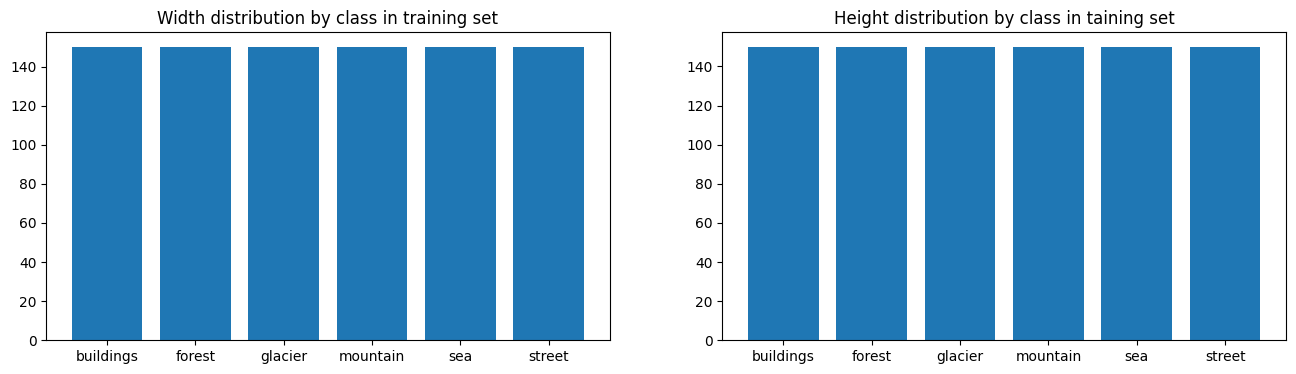

In [13]:
fig, axs = plt.subplots(1,2, figsize=(16,4))

axs[0].bar(range(len(df_test_grouped['width'].mean())), df_test_grouped['width'].mean(), tick_label=list(df_test_grouped.groups.keys()))
axs[0].set_title('Width distribution by class in training set')

axs[1].bar(range(len(df_test_grouped['height'].mean())), df_test_grouped['height'].mean(), tick_label=list(df_test_grouped.groups.keys()))
axs[1].set_title('Height distribution by class in taining set')
plt.show()

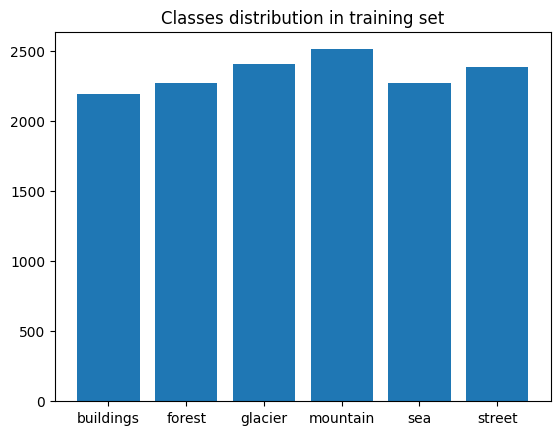

In [14]:
count_categorys = {}
for category in class_names:
    count_category = len(os.listdir(os.path.join(train_path, category)))
    count_categorys[category] = count_category
    
plt.bar(range(len(count_categorys)), list(count_categorys.values()), tick_label=list(count_categorys.keys()))
plt.title('Classes distribution in training set')
plt.show()

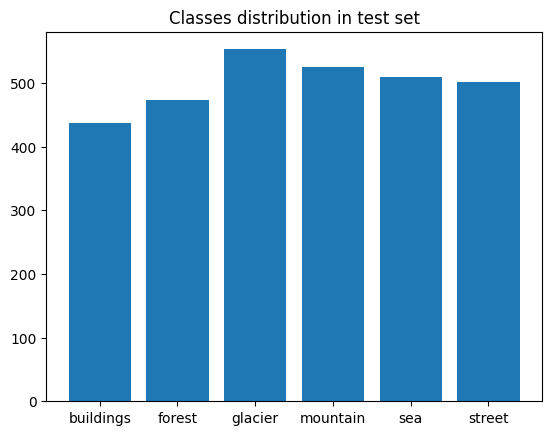

In [15]:
count_categorys = {}
for category in class_names:
    count_category = len(os.listdir(os.path.join(test_path, category)))
    count_categorys[category] = count_category
    
plt.bar(range(len(count_categorys)), list(count_categorys.values()), tick_label=list(count_categorys.keys()))
plt.title('Classes distribution in test set')
plt.show()

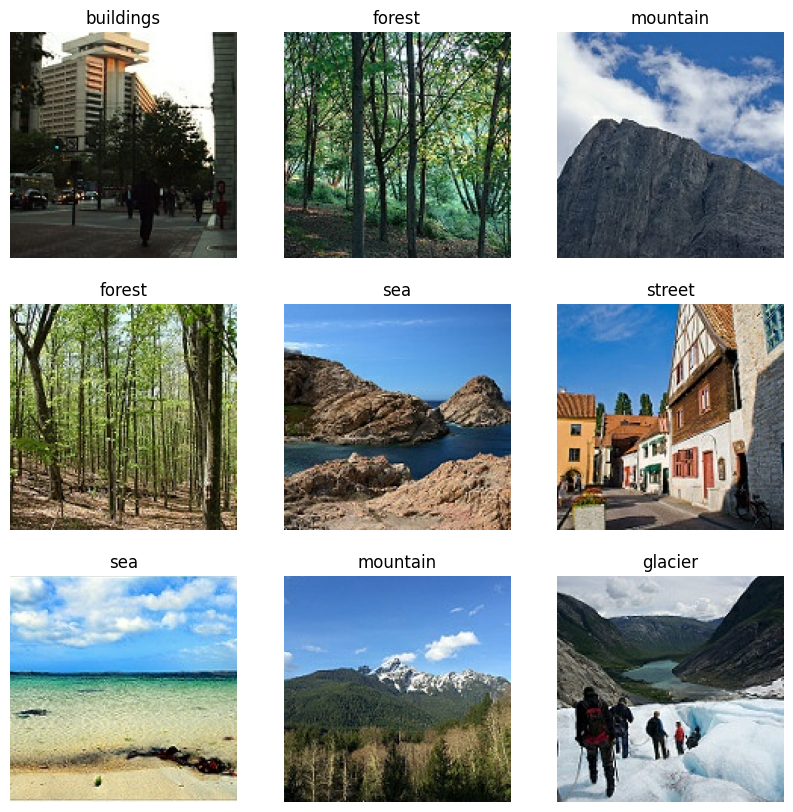

In [16]:
plt.figure(figsize=(10,10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
dropout_rate = 0.2
epochs = 40

In [19]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [20]:
def create_model(dropout_rate):
    model = tf.keras.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        keras.layers.Conv2D(16, (3,3), activation='relu'),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Flatten(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(6, activation='softmax')
    ])
    
    loss='categorical_crossentropy'
    optimizer='Adam'
    
    model.compile(optimizer=optimizer,
                 loss=loss,
                 metrics=['accuracy'])
    
    return model

In [21]:
history_simple = pd.DataFrame()
for drop_rate in tqdm([0.1, 0.2, 0.4]):
    model_simple = create_model(drop_rate)
    history = model_simple.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks=[lr_schedule], verbose=0)
    temp = pd.DataFrame()
    temp['accuracy'] = history.history['accuracy']
    temp['val_accuracy'] = history.history['val_accuracy']
    temp['loss'] = history.history['loss']
    temp['val_loss'] = history.history['val_loss']
    temp['lr'] = history.history['lr']
    temp['dropout_rate'] = drop_rate
    history_simple = pd.concat([history_simple, temp], axis=0)
    history_simple.reset_index(drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

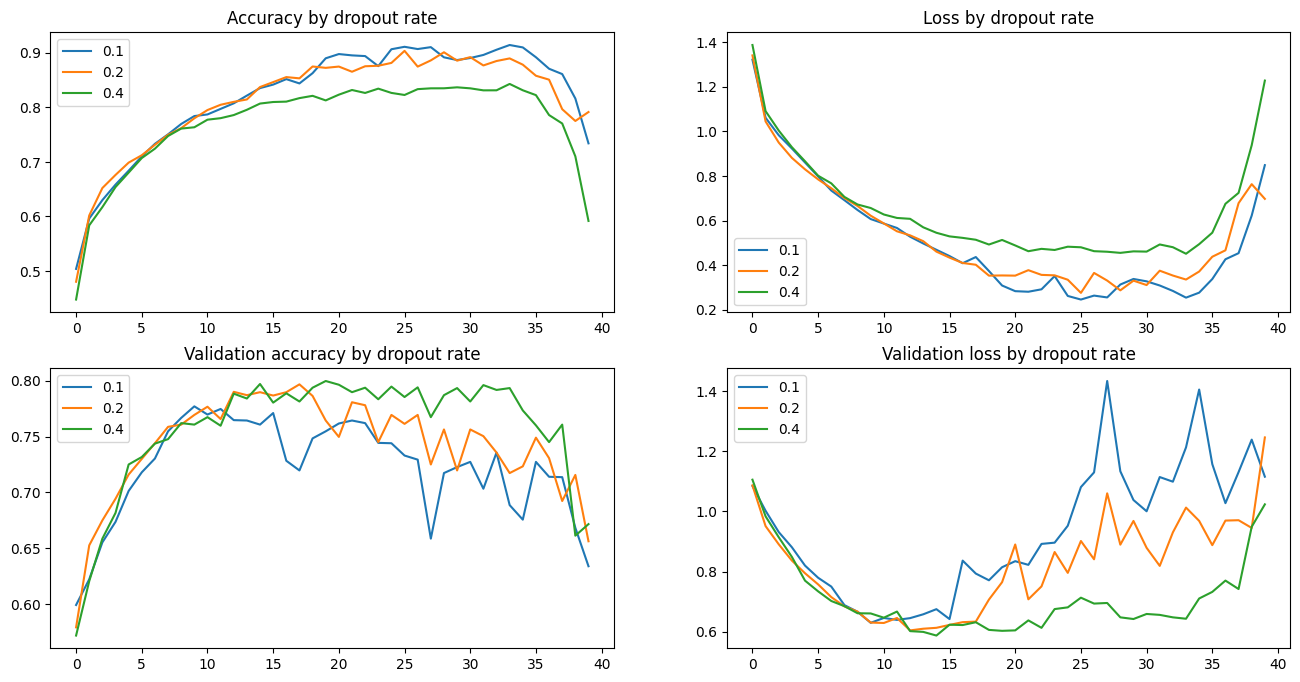

In [22]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
for i in [0.1, 0.2, 0.4]:
    temp_plot = history_simple[history_simple.dropout_rate==i]
    axs[0,0].plot(temp_plot.accuracy, label=i)
    axs[0,0].legend()
    axs[0,0].set_title('Accuracy by dropout rate')
    axs[1,0].plot(temp_plot.val_accuracy, label=i)
    axs[1,0].legend()
    axs[1,0].set_title('Validation accuracy by dropout rate')
    axs[0,1].plot(temp_plot.loss, label=i)
    axs[0,1].legend()
    axs[0,1].set_title('Loss by dropout rate')
    axs[1,1].plot(temp_plot.val_loss, label=i)
    axs[1,1].legend()
    axs[1,1].set_title('Validation loss by dropout rate')

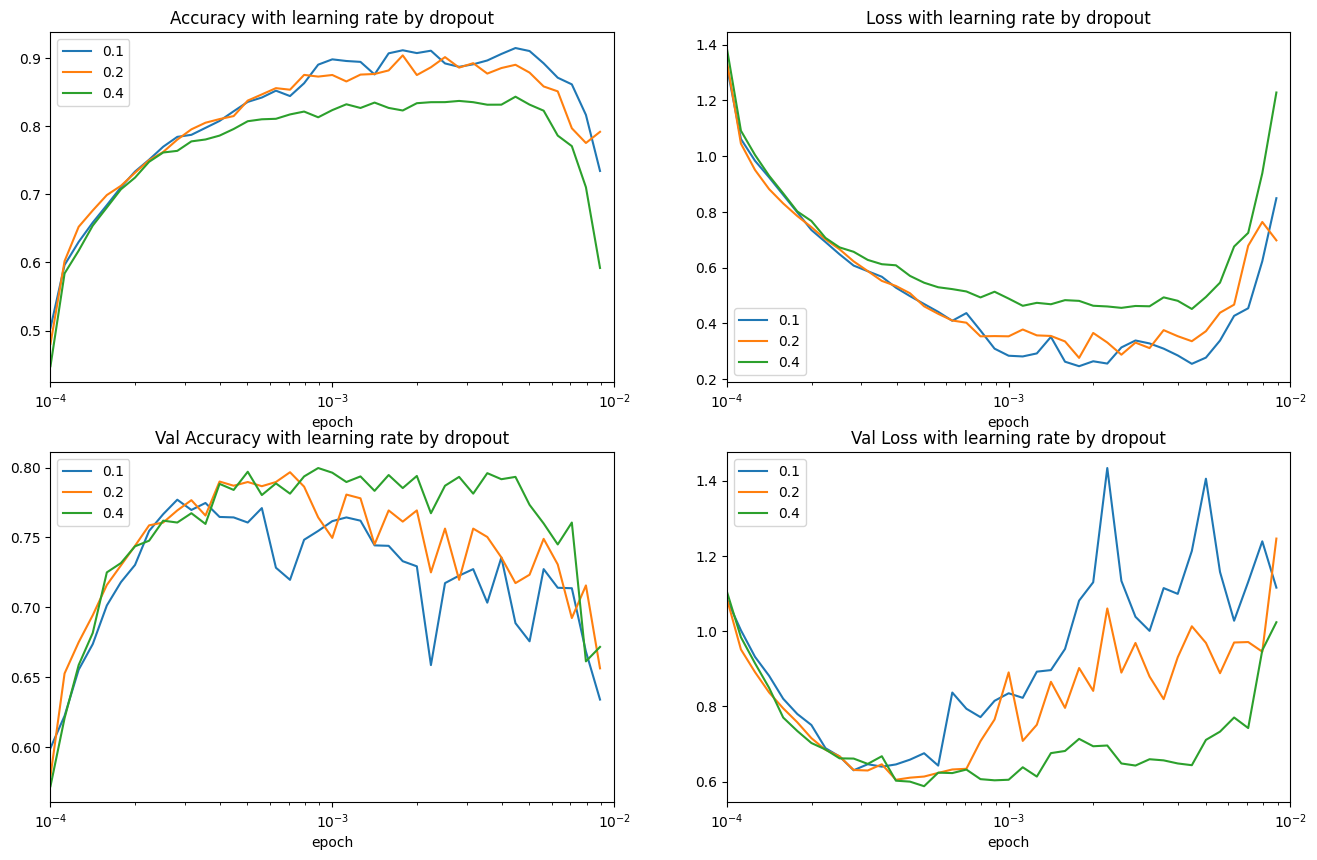

In [23]:
fig, axs = plt.subplots(2,2, figsize=(16,10))
for i in [0.1, 0.2, 0.4]:
    temp_plot = history_simple[history_simple.dropout_rate==i]
    
    axs[0,0].semilogx(temp_plot['lr'], temp_plot['accuracy'], label=i)
    axs[1,0].semilogx(temp_plot['lr'], temp_plot['val_accuracy'], label=i)
    axs[0,0].set_xlabel('epoch')
    axs[0,0].set_xlim(1e-4, 0.01)
    axs[0,0].legend()
    axs[0,0].set_title('Accuracy with learning rate by dropout')
    axs[1,0].set_xlabel('epoch')
    axs[1,0].set_xlim(1e-4, 0.01)
    axs[1,0].legend()
    axs[1,0].set_title('Val Accuracy with learning rate by dropout')
    
    axs[0,1].semilogx(temp_plot['lr'], temp_plot['loss'], label=i)
    axs[1,1].semilogx(temp_plot['lr'], temp_plot['val_loss'], label=i)
    axs[0,1].set_xlabel('epoch')
    axs[0,1].set_xlim(1e-4, 0.01)
    axs[0,1].legend()
    axs[0,1].set_title('Loss with learning rate by dropout')
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_xlim(1e-4, 0.01)
    axs[1,1].legend()
    axs[1,1].set_title('Val Loss with learning rate by dropout')

In [24]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomRotation(0.2),
])

In [25]:
def create_model_augmentation(dropout_rate):
    model = tf.keras.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        data_augmentation,
        keras.layers.Conv2D(16, (3,3), activation='relu'),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Flatten(),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(6, activation='softmax')
    ])
    
    loss='categorical_crossentropy'
    optimizer='Adam'
    
    model.compile(optimizer=optimizer,
                 loss=loss,
                 metrics=['accuracy'])
    
    return model

In [26]:
history_augment = pd.DataFrame()
for drop_rate in tqdm([0.1, 0.2, 0.4]):
    model_augment = create_model_augmentation(dropout_rate)
    history = model_augment.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks=[lr_schedule], verbose=0)
    temp = pd.DataFrame()
    temp['accuracy'] = history.history['accuracy']
    temp['val_accuracy'] = history.history['val_accuracy']
    temp['loss'] = history.history['loss']
    temp['val_loss'] = history.history['val_loss']
    temp['lr'] = history.history['lr']
    temp['dropout_rate'] = drop_rate
    history_augment = pd.concat([history_augment, temp], axis=0)
    history_augment.reset_index(drop=True)

  0%|          | 0/3 [00:00<?, ?it/s]

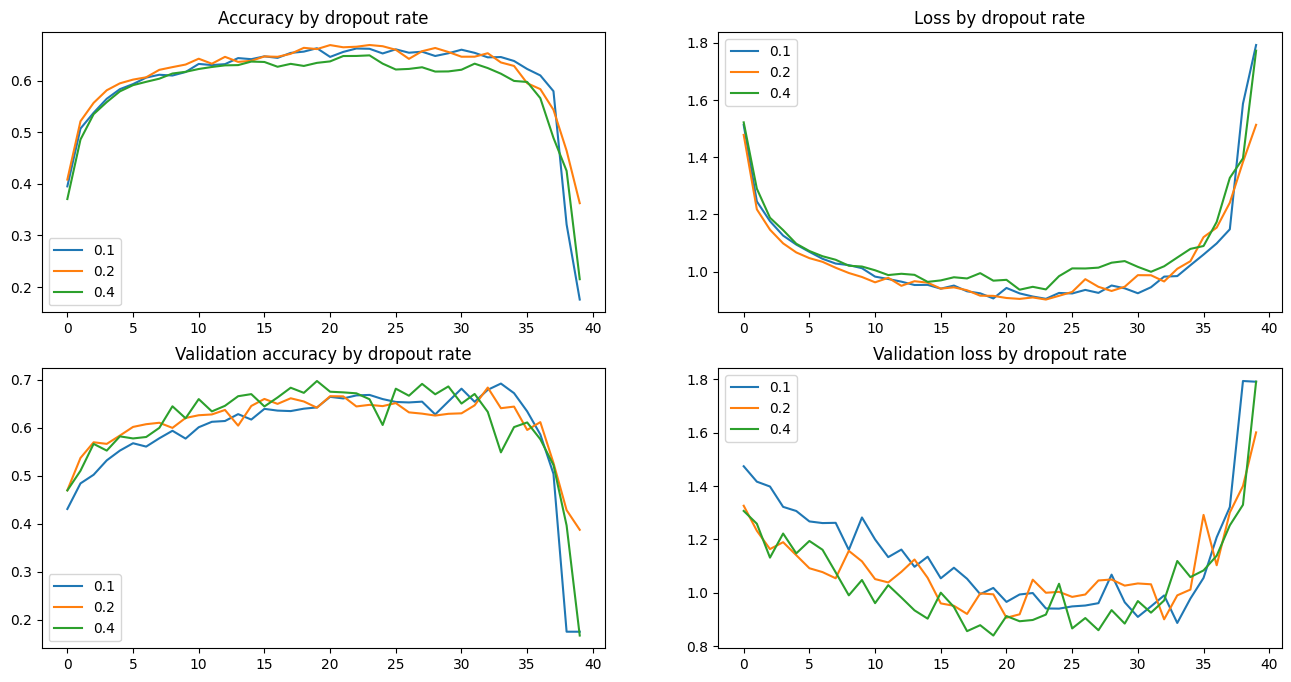

In [27]:
fig, axs = plt.subplots(2,2, figsize=(16,8))
for i in [0.1, 0.2, 0.4]:
    temp_plot = history_augment[history_augment.dropout_rate==i]
    axs[0,0].plot(temp_plot.accuracy, label=i)
    axs[0,0].legend()
    axs[0,0].set_title('Accuracy by dropout rate')
    axs[1,0].plot(temp_plot.val_accuracy, label=i)
    axs[1,0].legend()
    axs[1,0].set_title('Validation accuracy by dropout rate')
    axs[0,1].plot(temp_plot.loss, label=i)
    axs[0,1].legend()
    axs[0,1].set_title('Loss by dropout rate')
    axs[1,1].plot(temp_plot.val_loss, label=i)
    axs[1,1].legend()
    axs[1,1].set_title('Validation loss by dropout rate')

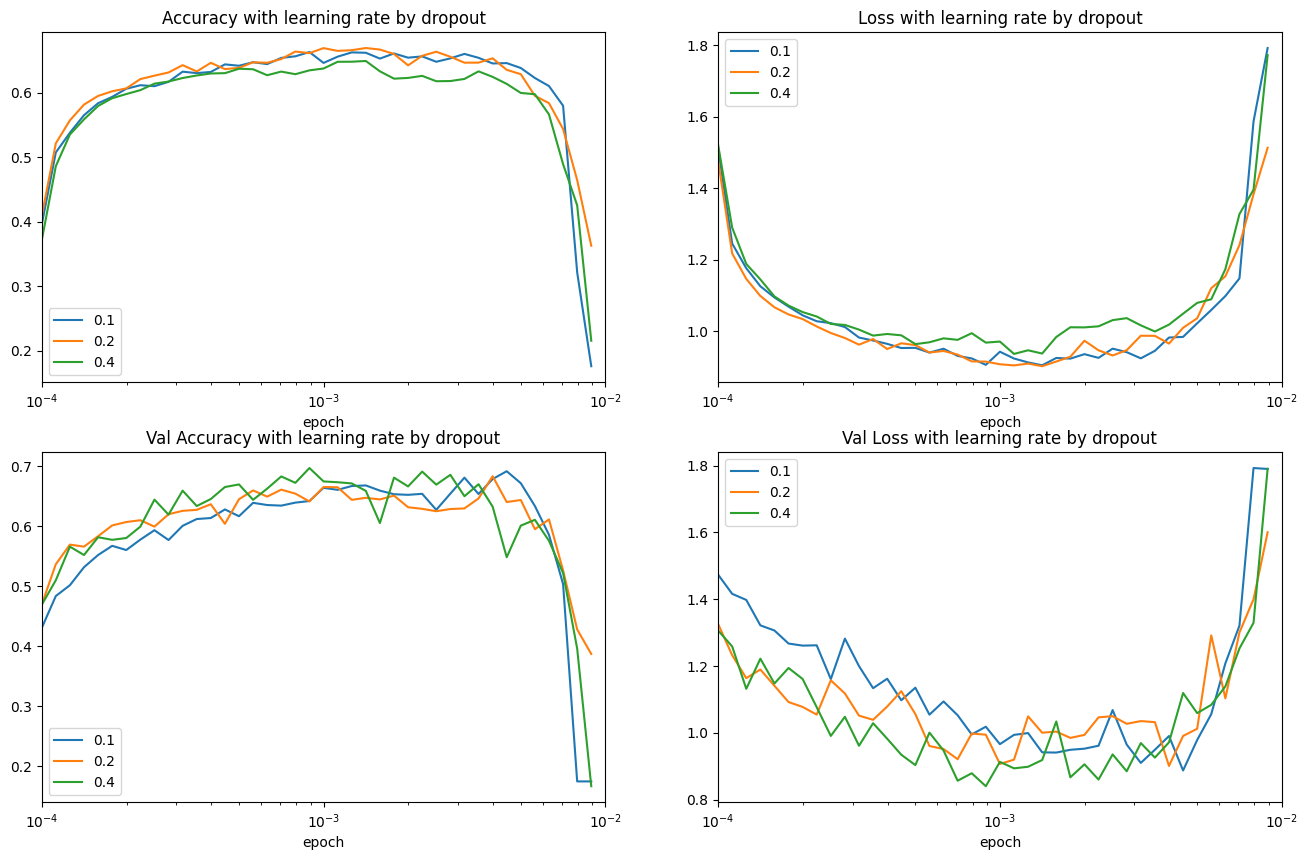

In [28]:
fig, axs = plt.subplots(2,2, figsize=(16,10))
for i in [0.1, 0.2, 0.4]:
    temp_plot = history_augment[history_augment.dropout_rate==i]
    
    axs[0,0].semilogx(temp_plot['lr'], temp_plot['accuracy'], label=i)
    axs[1,0].semilogx(temp_plot['lr'], temp_plot['val_accuracy'], label=i)
    axs[0,0].set_xlabel('epoch')
    axs[0,0].set_xlim(1e-4, 0.01)
    axs[0,0].legend()
    axs[0,0].set_title('Accuracy with learning rate by dropout')
    axs[1,0].set_xlabel('epoch')
    axs[1,0].set_xlim(1e-4, 0.01)
    axs[1,0].legend()
    axs[1,0].set_title('Val Accuracy with learning rate by dropout')
    
    axs[0,1].semilogx(temp_plot['lr'], temp_plot['loss'], label=i)
    axs[1,1].semilogx(temp_plot['lr'], temp_plot['val_loss'], label=i)
    axs[0,1].set_xlabel('epoch')
    axs[0,1].set_xlim(1e-4, 0.01)
    axs[0,1].legend()
    axs[0,1].set_title('Loss with learning rate by dropout')
    axs[1,1].set_xlabel('epoch')
    axs[1,1].set_xlim(1e-4, 0.01)
    axs[1,1].legend()
    axs[1,1].set_title('Val Loss with learning rate by dropout')

In [29]:
def create_model_transfer(dropout_rate):
    base_model = keras.applications.Xception(
                                            weights='imagenet',
                                            input_shape=(height, width, 3),
                                            include_top=False)
    
    base_model.trainable = False
    
    inputs = keras.layers.Input(shape=(height, width, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(32, activation='relu')(vectors)
    drop = keras.layers.Dropout(dropout_rate)(inner)
    outputs = keras.layers.Dense(6, activation='softmax')(drop)

    model = keras.Model(inputs, outputs)
    
    loss='categorical_crossentropy'
    optimizer='Adam'
    
    model.compile(optimizer=optimizer,
                     loss=loss,
                     metrics=['accuracy'])
    
    return model

In [30]:
model_transfer = create_model_transfer(dropout_rate)

In [31]:
history = model_transfer.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks=[lr_schedule], verbose=0)

Text(0.5, 1.0, 'Loss')

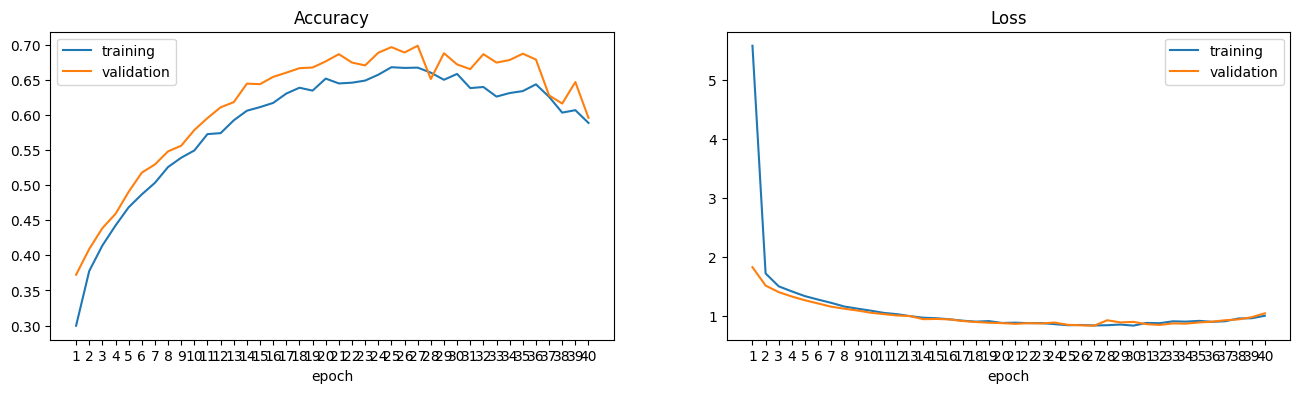

In [32]:
fig, axs = plt.subplots(1,2, figsize=(16,4))

axs[0].plot(range(1,epochs+1), history.history['accuracy'])
axs[0].plot(range(1,epochs+1), history.history['val_accuracy'])
axs[0].set_xlabel('epoch')
axs[0].set_xticks(range(1,epochs+1))
axs[0].legend(['training', 'validation'])
axs[0].set_title('Accuracy')

axs[1].plot(range(1,epochs+1), history.history['loss'])
axs[1].plot(range(1,epochs+1), history.history['val_loss'])
axs[1].set_xlabel('epoch')
axs[1].set_xticks(range(1,epochs+1))
axs[1].legend(['training', 'validation'])
axs[1].set_title('Loss')

Text(0.5, 1.0, 'Loss')

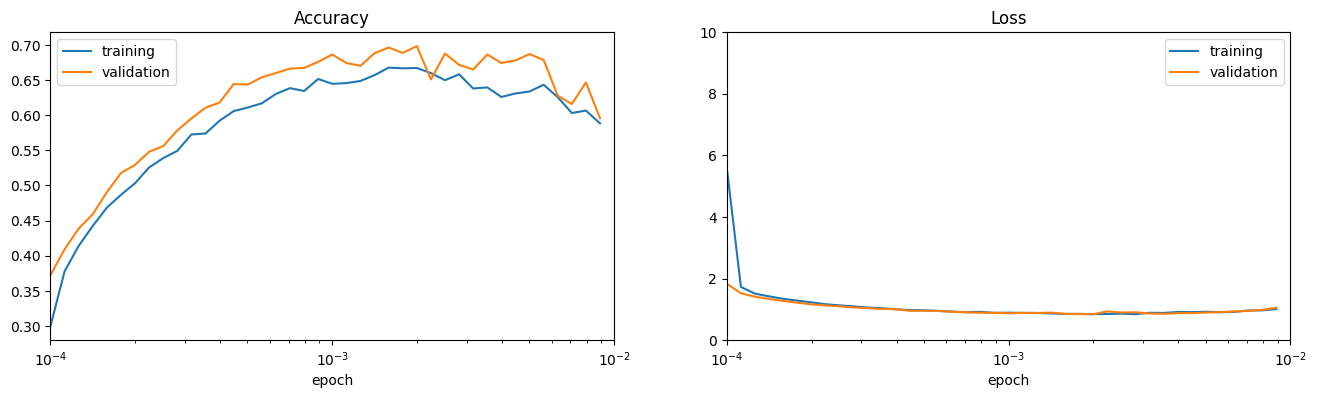

In [33]:
fig, axs = plt.subplots(1,2, figsize=(16,4))

axs[0].semilogx(history.history['lr'], history.history['accuracy'])
axs[0].semilogx(history.history['lr'], history.history['val_accuracy'])
axs[0].set_xlabel('epoch')
axs[0].set_xlim(1e-4, 0.01)
#axs[0].set_xticks(range(1,epochs+1))
axs[0].legend(['training', 'validation'])
axs[0].set_title('Accuracy')

axs[1].semilogx(history.history['lr'], history.history['loss'])
axs[1].semilogx(history.history['lr'], history.history['val_loss'])
axs[1].set_xlabel('epoch')
axs[1].set_xlim(1e-4, 0.01)
axs[1].set_ylim(0, 10)
#axs[1].set_xticks(range(1,epochs+1))
axs[1].legend(['training', 'validation'])
axs[1].set_title('Loss')

In [34]:
final_model = tf.keras.Sequential([
        keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        keras.layers.Conv2D(16, (3,3), activation='relu'),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        keras.layers.MaxPooling2D(2,2),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(6, activation='softmax')
    ])
    
loss=tf.keras.losses.CategoricalCrossentropy()
optimizer=tf.keras.optimizers.Adam(0.001)
    
final_model.compile(optimizer=optimizer,
                 loss=loss,
                 metrics=['accuracy'])

In [35]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.81):
      print("\nReached 81% validation accuracy so cancelling training!")
      self.model.stop_training = True

In [36]:
callbacks = myCallback()

In [37]:
history = final_model.fit(train_ds, epochs=epochs, validation_data=(val_ds), callbacks=callbacks)

Epoch 1/40
110/110 [==============================] - 6s 35ms/step - loss: 1.2163 - accuracy: 0.5192 - val_loss: 0.9394 - val_accuracy: 0.6490
Epoch 2/40
110/110 [==============================] - 4s 34ms/step - loss: 0.9433 - accuracy: 0.6350 - val_loss: 0.8590 - val_accuracy: 0.6680
Epoch 3/40
110/110 [==============================] - 4s 34ms/step - loss: 0.8579 - accuracy: 0.6776 - val_loss: 0.8129 - val_accuracy: 0.6973
Epoch 4/40
110/110 [==============================] - 4s 34ms/step - loss: 0.7787 - accuracy: 0.7082 - val_loss: 0.7187 - val_accuracy: 0.7380
Epoch 5/40
110/110 [==============================] - 4s 34ms/step - loss: 0.7483 - accuracy: 0.7222 - val_loss: 0.6907 - val_accuracy: 0.7530
Epoch 6/40
110/110 [==============================] - 4s 34ms/step - loss: 0.6798 - accuracy: 0.7497 - val_loss: 0.6762 - val_accuracy: 0.7587
Epoch 7/40
110/110 [==============================] - 4s 34ms/step - loss: 0.6433 - accuracy: 0.7676 - val_loss: 0.6896 - val_accuracy: 0.7600

Text(0.5, 1.0, 'Loss')

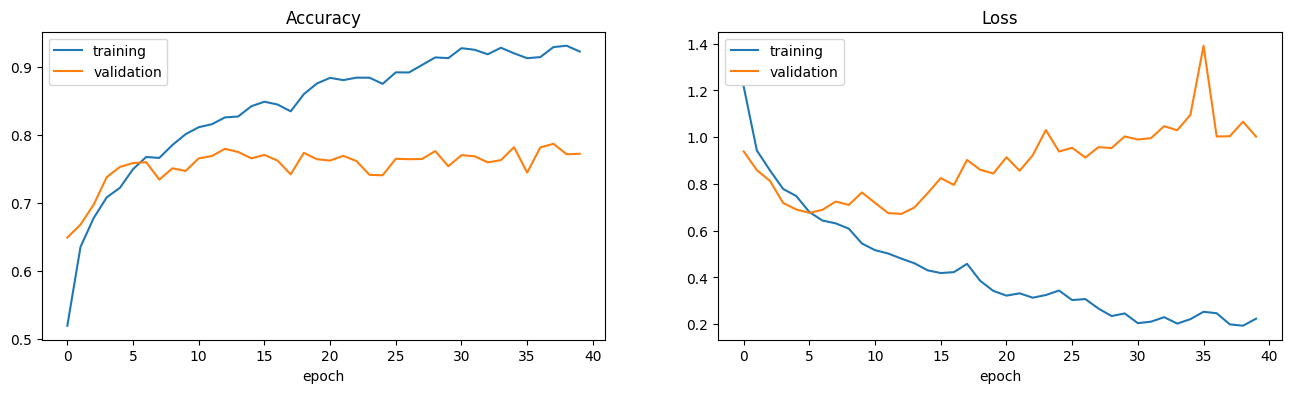

In [38]:
fig, axs = plt.subplots(1,2, figsize=(16,4))

axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_xlabel('epoch')

axs[0].legend(['training', 'validation'])
axs[0].set_title('Accuracy')

axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_xlabel('epoch')

axs[1].legend(['training', 'validation'])
axs[1].set_title('Loss')

In [39]:
import pickle

In [40]:
output_file = 'model_final.bin'

In [41]:
f_out = open(output_file, 'wb')
pickle.dump((final_model), f_out)
f_out.close()